## 1. Import Libraries & Setup

In [52]:
import pandas as pd
import numpy as np
import re
import warnings
import time
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
# nltk.download('punkt', quiet=True)
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('punkt_tab', quiet=True)

print("Setup complete!")

Setup complete!


## 2. Data Loading & Exploration

In [53]:
# Load datasets - Using BOTH True/Fake and WELFake datasets combined
print("Loading datasets...")

# ---------------- Load True / Fake ----------------
real_news_1 = pd.read_csv('True.csv')
fake_news_1 = pd.read_csv('Fake.csv')

# Add labels
real_news_1['label'] = 1
fake_news_1['label'] = 0

# Keep only needed columns
required_cols = ['title', 'text', 'label']
real_news_1 = real_news_1[required_cols]
fake_news_1 = fake_news_1[required_cols]

print(f"✓ True.csv: {len(real_news_1)} real articles")
print(f"✓ Fake.csv: {len(fake_news_1)} fake articles")

# ---------------- Load WELFake ----------------
df_welfake = pd.read_csv('WELFake_Dataset.csv')

# Ensure correct label column
if 'news_label' in df_welfake.columns:
    df_welfake = df_welfake.rename(columns={'news_label': 'label'})

# Check for required columns
missing_cols = [c for c in required_cols if c not in df_welfake.columns]
if missing_cols:
    raise ValueError(f"WELFake_Dataset.csv missing columns: {missing_cols}")

# Keep only needed columns
df_welfake = df_welfake[required_cols]

# FIX: WELFake uses 0=real, 1=fake, so we need to FLIP it to match True/Fake convention
df_welfake['label'] = 1 - df_welfake['label']  # Now: 1=real, 0=fake

real_news_2 = df_welfake[df_welfake['label'] == 1].copy()
fake_news_2 = df_welfake[df_welfake['label'] == 0].copy()

print(f"✓ WELFake_Dataset.csv: {len(real_news_2)} real, {len(fake_news_2)} fake articles")

# ---------------- Combine & Mix All Datasets ----------------
# Mix both real and fake from both sources to avoid dataset bias
all_data = []
all_data.append(real_news_1)
all_data.append(fake_news_1)
all_data.append(real_news_2)
all_data.append(fake_news_2)

# Concatenate all data at once
df = pd.concat(all_data, ignore_index=True)

# Shuffle thoroughly with different random state to ensure good mixing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# Second shuffle for extra mixing
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

dataset_name = "True.csv + Fake.csv + WELFake_Dataset.csv (Combined & Mixed)"

# ---------------- Common Processing ----------------
print(f"\nUsing dataset: {dataset_name}")
print(f"Total samples: {len(df)}")
print(f"Real: {df['label'].sum()} | Fake: {(df['label']==0).sum()}")

# Create full text
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Remove any rows with empty full_text
df = df[df['full_text'].str.strip() != ''].reset_index(drop=True)
print(f"After removing empty texts: {len(df)} samples")

Loading datasets...
✓ True.csv: 21417 real articles
✓ Fake.csv: 23481 fake articles
✓ WELFake_Dataset.csv: 35028 real, 37106 fake articles

Using dataset: True.csv + Fake.csv + WELFake_Dataset.csv (Combined & Mixed)
Total samples: 117032
Real: 56445 | Fake: 60587
After removing empty texts: 117032 samples


### Data Visualization

## 3. Comprehensive Dataset Analysis & Visualization

### 3.1 Dataset Information

In [54]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117032 entries, 0 to 117031
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      116474 non-null  object
 1   text       116993 non-null  object
 2   label      117032 non-null  int64 
 3   full_text  117032 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.6+ MB


### 3.2 Class Imbalance Analysis

Total Articles: 117,032
Fake News: 60,587 (51.77%)
Real News: 56,445 (48.23%)


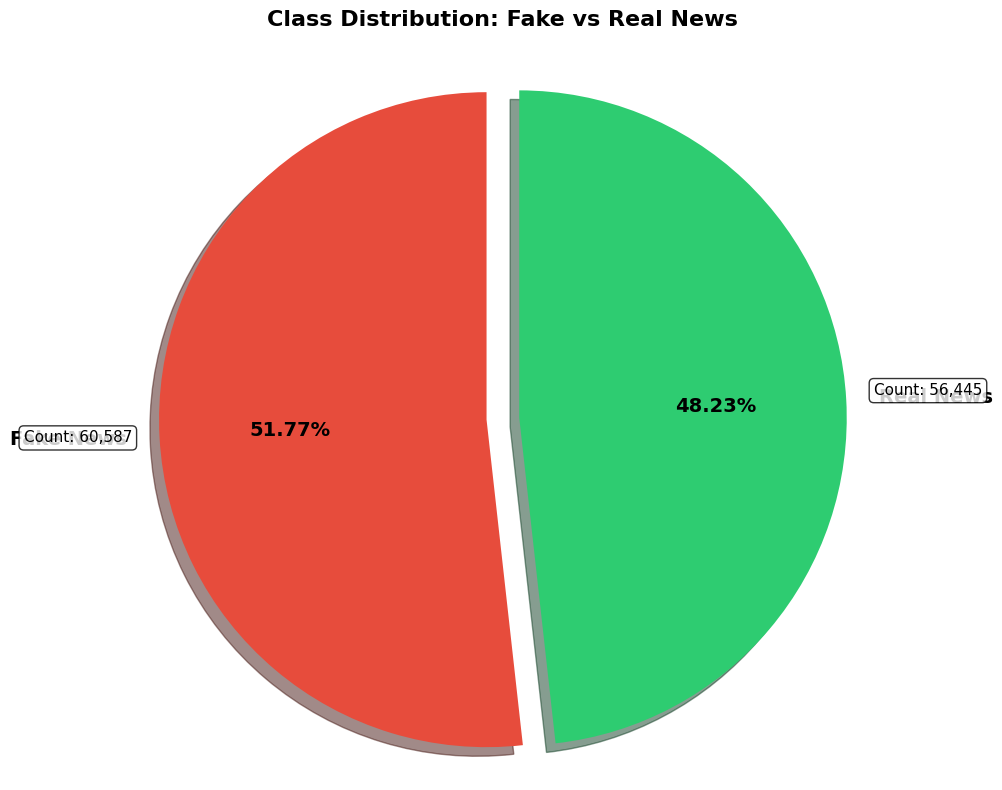

In [55]:
# Calculate class distribution and percentages
fake_count = (df['label'] == 0).sum()
real_count = (df['label'] == 1).sum()
total_count = len(df)

fake_percent = (fake_count / total_count) * 100
real_percent = (real_count / total_count) * 100

print(f"Total Articles: {total_count:,}")
print(f"Fake News: {fake_count:,} ({fake_percent:.2f}%)")
print(f"Real News: {real_count:,} ({real_percent:.2f}%)")

# Create pie chart for class imbalance
plt.figure(figsize=(10, 8))
colors = ['#e74c3c', '#2ecc71']
explode = (0.05, 0.05)

wedges, texts, autotexts = plt.pie(
    [fake_count, real_count],
    labels=['Fake News', 'Real News'],
    autopct='%1.2f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 14, 'fontweight': 'bold'}
)

plt.title('Class Distribution: Fake vs Real News\n', fontsize=16, fontweight='bold')

# Add count annotations
for i, (wedge, count) in enumerate(zip(wedges, [fake_count, real_count])):
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle))
    label = f'Count: {count:,}'
    plt.annotate(label, xy=(x*1.3, y*1.3), fontsize=11, ha='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.axis('equal')
plt.tight_layout()
plt.show()

### 3.3 Word Cloud Visualizations

In [56]:
# Install wordcloud if needed
try:
    from wordcloud import WordCloud
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'wordcloud'])
    from wordcloud import WordCloud

# Prepare text data
real_news_text = ' '.join(df[df['label'] == 1]['full_text'].astype(str))
fake_news_text = ' '.join(df[df['label'] == 0]['full_text'].astype(str))
all_text = ' '.join(df['full_text'].astype(str))

In [58]:
# Word Cloud for Real News
print("Generating Word Cloud for Real News...")
wordcloud_real = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='Greens',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10
).generate(real_news_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Real News', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

Generating Word Cloud for Real News...


MemoryError: 

In [ ]:
# Word Cloud for Fake News
print("Generating Word Cloud for Fake News...")
wordcloud_fake = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='Reds',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10
).generate(fake_news_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Fake News', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Word Cloud for Overall Dataset
print("Generating Word Cloud for Overall Dataset...")
wordcloud_all = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='viridis',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10
).generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Overall Dataset (Fake + Real)', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

### 3.4 Top 20 Most Frequent Words

In [ ]:
# Calculate top 20 words from the overall dataset
from collections import Counter
import re

# Clean and tokenize text
def get_words(text):
    # Convert to lowercase and extract words
    words = re.findall(r'\b[a-z]{3,}\b', text.lower())
    # Remove common stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    return words

all_words = get_words(all_text)
word_freq = Counter(all_words)
top_20 = word_freq.most_common(20)

# Create visualization
words, counts = zip(*top_20)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(words)), counts, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(words))))
plt.yticks(range(len(words)), words, fontsize=12)
plt.xlabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Top 20 Most Frequent Words in Dataset', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(count + max(counts)*0.01, i, f'{count:,}', 
             va='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [ ]:
# Train-Test Split (80-20)
X = df['full_text']
y = df['label']

# Verify label distribution before split
print(f"Label distribution before split:")
print(y.value_counts())
print(f"Fake: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"Real: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.2f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {len(X_train)} samples")
print(f"  - Fake: {(y_train==0).sum()}, Real: {(y_train==1).sum()}")
print(f"Testing Set: {len(X_test)} samples")
print(f"  - Fake: {(y_test==0).sum()}, Real: {(y_test==1).sum()}")

In [ ]:
# Text Preprocessing Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess text: lowercase, remove URLs, HTML, special chars, stopwords, lemmatize"""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    
    return ' '.join(tokens)

print("Preprocessing training data...")
X_train_processed = X_train.apply(preprocess_text)
print("Preprocessing testing data...")
X_test_processed = X_test.apply(preprocess_text)
print("Preprocessing complete!")

## 4. TF-IDF Vectorization
Convert text to numerical features for traditional ML models

In [ ]:
# TF-IDF Vectorizer
# Optimized parameters for combined dataset
tfidf = TfidfVectorizer(
    max_features=5000,  # Increased for larger combined dataset
    ngram_range=(1, 1),  # Include unigrams only
    min_df=100,  # Lowered to capture more features
    max_df=0.1,  # Slightly more strict to remove very common words
    sublinear_tf=True  # Use sublinear term frequency scaling
)

print("Fitting TF-IDF vectorizer...")
X_train_tfidf = tfidf.fit_transform(X_train_processed)
X_test_tfidf = tfidf.transform(X_test_processed)

print(f"TF-IDF Features: {X_train_tfidf.shape[1]}")
print(f"Training samples: {X_train_tfidf.shape[0]}")
print(f"Test samples: {X_test_tfidf.shape[0]}")

---
## 5. Model Training & Evaluation
Training 2 traditional ML models: Logistic Regression & Random Forest

In [ ]:
# Dictionary to store results
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, train_time):
    """Evaluate model and store results"""
    y_pred = model.predict(X_test)
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'train_time': train_time,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"\n{'='*60}")
    print(f"{name.upper()}")
    print(f"{'='*60}")
    print(f"Training Time: {train_time:.2f}s")
    print(f"Accuracy:      {results[name]['accuracy']:.4f} ({results[name]['accuracy']*100:.2f}%)")
    print(f"Precision:     {results[name]['precision']:.4f}")
    print(f"Recall:        {results[name]['recall']:.4f}")
    print(f"F1-Score:      {results[name]['f1']:.4f}")

### Model 1: Logistic Regression

In [ ]:
print("Training Logistic Regression...")
start_time = time.time()
lr_model = LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Logistic Regression', lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

### Model 4: Random Forest

In [ ]:
print("Training Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Random Forest', rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

In [ ]:
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save all trained models
print("Saving models...")

# Save TF-IDF vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("✓ TF-IDF vectorizer saved")

# Save Logistic Regression
with open('models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✓ Logistic Regression saved")

# Save Random Forest
with open('models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ Random Forest saved")

print("\nAll models saved successfully in 'models/' directory!")

---
## 6. Comprehensive Model Evaluation & Visualization

In [ ]:
# Import additional libraries for ROC and Precision-Recall curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Store predictions and probabilities for all models
model_predictions = {
    'Logistic Regression': {
        'model': lr_model,
        'y_pred': lr_model.predict(X_test_tfidf),
        'y_pred_proba': lr_model.predict_proba(X_test_tfidf)[:, 1]
    },
    'Random Forest': {
        'model': rf_model,
        'y_pred': rf_model.predict(X_test_tfidf),
        'y_pred_proba': rf_model.predict_proba(X_test_tfidf)[:, 1]
    }
}

print("Model predictions stored successfully!")

### 6.1 Logistic Regression - Detailed Evaluation

In [ ]:
# Logistic Regression - Classification Report
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, model_predictions['Logistic Regression']['y_pred'], 
                          target_names=['Fake', 'Real'], digits=4))

In [ ]:
# Logistic Regression - Confusion Matrix
cm_lr = confusion_matrix(y_test, model_predictions['Logistic Regression']['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Logistic Regression - Confusion Matrix\nAccuracy: {:.4f}'.format(
    results['Logistic Regression']['accuracy']), fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Logistic Regression - ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, model_predictions['Logistic Regression']['y_pred_proba'])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=3, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Logistic Regression - ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Logistic Regression - Precision-Recall Curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, model_predictions['Logistic Regression']['y_pred_proba'])
avg_precision_lr = average_precision_score(y_test, model_predictions['Logistic Regression']['y_pred_proba'])

plt.figure(figsize=(10, 8))
plt.plot(recall_lr, precision_lr, color='blue', lw=3, 
         label=f'Logistic Regression (AP = {avg_precision_lr:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Logistic Regression - Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

### 6.2 Random Forest - Detailed Evaluation

In [ ]:
# Random Forest - Classification Report
print("Random Forest - Classification Report:")
print(classification_report(y_test, model_predictions['Random Forest']['y_pred'], 
                          target_names=['Fake', 'Real'], digits=4))

In [ ]:
# Random Forest - Confusion Matrix
cm_rf = confusion_matrix(y_test, model_predictions['Random Forest']['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Random Forest - Confusion Matrix\nAccuracy: {:.4f}'.format(
    results['Random Forest']['accuracy']), fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix statistics
tn, fp, fn, tp = cm_rf.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Fake correctly identified):  {tn:,}")
print(f"False Positives (Fake predicted as Real):    {fp:,}")
print(f"False Negatives (Real predicted as Fake):    {fn:,}")
print(f"True Positives (Real correctly identified):  {tp:,}")

In [ ]:
# Random Forest - ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_predictions['Random Forest']['y_pred_proba'])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='green', lw=3, 
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Random Forest - ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Random Forest - Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, model_predictions['Random Forest']['y_pred_proba'])
avg_precision_rf = average_precision_score(y_test, model_predictions['Random Forest']['y_pred_proba'])

plt.figure(figsize=(10, 8))
plt.plot(recall_rf, precision_rf, color='green', lw=3, 
         label=f'Random Forest (AP = {avg_precision_rf:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Random Forest - Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

### 6.3 Comprehensive Model Comparison

In [ ]:
# Comparative Bar Graph - All Metrics
model_names = ['Logistic Regression', 'Random Forest']
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors_map = {'Logistic Regression': '#FF6B6B', 'Random Forest': '#4ECDC4'}

for idx, metric in enumerate(metrics_to_compare):
    values = [results[model][metric] for model in model_names]
    colors = [colors_map[model] for model in model_names]
    
    bars = axes[idx].bar(model_names, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[idx].set_ylabel(metric.capitalize(), fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{metric.capitalize()} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_ylim([0.8, 1.0])
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{val:.4f}', ha='center', va='bottom', 
                      fontsize=11, fontweight='bold')

plt.suptitle('Comprehensive Model Performance Comparison', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Comparative ROC Curves - All Models
plt.figure(figsize=(12, 9))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, model_predictions['Logistic Regression']['y_pred_proba'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='#FF6B6B', lw=3, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_predictions['Random Forest']['y_pred_proba'])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='#4ECDC4', lw=3, 
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')

# Random classifier baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Comparative ROC Curves - All Models', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12, framealpha=0.9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Comparative Analysis Summary
print("\nModel Performance Summary:")
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [results[m]['accuracy'] for m in model_names],
    'Precision': [results[m]['precision'] for m in model_names],
    'Recall': [results[m]['recall'] for m in model_names],
    'F1-Score': [results[m]['f1'] for m in model_names],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf],
    'Training Time (s)': [results[m]['train_time'] for m in model_names]
})

print(comparison_df.to_string(index=False))

---
## 8. Key Insights & Recommendations

In [ ]:
# Best model analysis
best_model = comparison_df.idxmax()['accuracy']
best_accuracy = comparison_df.loc[best_model, 'accuracy']

print(f"\nBest Model: {best_model}")
print(f"Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

---
## 9. Interactive Testing (Optional)
Test models on custom news articles

In [ ]:
def _prob_fake_real(model, text_tfidf):
    """Return tuple (p_fake, p_real) for binary models; fall back to 0.5/0.5 if unavailable."""
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(text_tfidf)[0]
        if len(probs) == 2:
            if hasattr(model, "classes_"):
                cls = list(model.classes_)
                p_fake = probs[cls.index(0)] if 0 in cls else probs[0]
                p_real = probs[cls.index(1)] if 1 in cls else probs[-1]
            else:
                p_fake, p_real = probs[0], probs[1]
            return float(p_fake), float(p_real)
    if hasattr(model, "decision_function"):
        margin = model.decision_function(text_tfidf)[0]
        p_real = 1.0 / (1.0 + np.exp(-margin))
        p_fake = 1.0 - p_real
        return float(p_fake), float(p_real)
    return 0.5, 0.5


def predict_news(text, model_name='Logistic Regression'):
    """Predict if a news article is real or fake with a single model"""
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model
    }
    
    if model_name not in model_map:
        print(f"Model '{model_name}' not available. Using Logistic Regression.")
        model_name = 'Logistic Regression'
    
    model = model_map[model_name]
    pred = model.predict(text_tfidf)[0]
    result = "REAL" if pred == 1 else "FAKE"
    p_fake, p_real = _prob_fake_real(model, text_tfidf)
    
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} PREDICTION:")
    print("-" * 60)
    print(f"Prediction: {result} {'✔' if result=='REAL' else '✗'}")
    print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%")
    print(f"{'='*60}")
    return result


def predict_all_models(text):
    """Predict with every available model; print prediction and confidence."""
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model
    }
    
    summary = {}
    for name, model in model_map.items():
        pred = model.predict(text_tfidf)[0]
        label = 'REAL' if pred == 1 else 'FAKE'
        p_fake, p_real = _prob_fake_real(model, text_tfidf)
        acc = results.get(name, {}).get('accuracy', None)
        summary[name] = {
            'prediction': label,
            'p_fake': p_fake,
            'p_real': p_real,
            'accuracy': acc,
        }
        acc_display = f" | accuracy: {acc:.4f}" if acc is not None else ""
        print(f"\n{name.upper()} PREDICTION:")
        print("-" * 60)
        print(f"Prediction: {label} {'✔' if label=='REAL' else '✗'}")
        print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%{acc_display}")
    
    return summary

In [ ]:
sample_text = """
Iran warns it will retaliate if US attacks, as hundreds killed in protests
Iran has warned it will retaliate if attacked by the US, as BBC sources and activists report hundreds of protesters have now been killed in an escalating government crackdown.

"Things here are very, very bad," a source in Tehran said on Sunday. "A lot of our friends have been killed. They were firing live rounds. It's like a war zone, the streets are full of blood. They're taking away bodies in trucks."

The BBC counted about 180 body bags in footage from a morgue near Tehran. The US-based Human Rights Activist News Agency says it has verified the deaths of 495 protesters and 48 security personnel nationwide.

Another 10,600 people have been detained over the fortnight of unrest, the agency says.

The US has threatened to intervene in Iran over the killing of protesters, but on Sunday, US President Donald Trump said that Iranian leaders had called him and that "they want to negotiate".

He added, however, that the US "may have to act before a meeting".

Trump has not elaborated on what the US is considering, but on Sunday he said "we're looking at some very strong options". He has been briefed on options for military strikes on Iran, an official told the BBC's US news partner CBS.

Other approaches could include boosting anti-government sources online, using cyber-weapons against Iran's military, or imposing more sanctions, officials told the Wall Street Journal.

Iran's parliament speaker warned that if the US attacked, both Israel and US military and shipping centres in the region would become legitimate targets.

The protests which began over soaring inflation are now calling for an end to the clerical rule of Iran's Supreme Leader, Ayatollah Ali Khamenei.

Iran's attorney general said anyone protesting would be considered an "enemy of God" - an offence that carries the death penalty - while Khamenei has dismissed demonstrators as a "bunch of vandals" seeking to "please" Trump.

On Sunday the country announced three days of mourning for what it called "martyrs killed in Iranian national battle against the US and Israel".

Staff at several hospitals have told the BBC they have been overwhelmed with dead or injured protesters in recent days.

BBC Persian has verified that 70 bodies were brought to one hospital in the city of Rasht on Friday night, while a health worker at a Tehran hospital told the BBC: "Around 38 people died. Many as soon as they reached the emergency beds... direct shots to the heads of the young people, to their hearts as well. Many of them didn't even make it to the hospital."

The BBC and most other international news organisations are unable to report from inside Iran, and the Iranian government has imposed an internet shutdown since Thursday, making obtaining and verifying information difficult.

Some footage has emerged, including video showing rows of body bags at the Forensic Diagnostic and Laboratory Center of Tehran Province - a morgue in Kahrizak.

In one video from the site, about 180 shrouded or wrapped figures can be seen, the majority lying out in the open. Shouts and cries of distress can be heard from people who appear to be looking for their loved ones.

Footage has been blurred to protect the identities of the living, who could face further persecution from the authorities.

Several videos confirmed as recent by BBC Verify show clashes between protesters and security forces in Mashhad, Iran's second-largest city.

Masked protesters can be seen taking cover behind bins and bonfires, with a row of security forces in the distance. A vehicle that appears to be a bus is engulfed in flames.

Multiple gunshots can be heard, and what sounds like banging on pots and pans.

A figure standing on a nearby footbridge appears to fire multiple gunshots in several directions as a couple of people take cover behind a fence.

In Tehran, a verified video from Saturday night shows protesters taking over the streets in the Gisha district, the sound of banging on pots in Punak Square, and a crowd marching and calling for the end of clerical rule in the Heravi district.

"""
#https://www.bbc.com/news/articles/cm2jek15m8no the link for real news
predict_all_models(sample_text)

---
## 10. Ensemble Learning
Combining multiple models for improved predictions

In [ ]:
# Ensemble Methods: Combining predictions from LR and RF
import warnings
warnings.filterwarnings('ignore')

print("Ensemble Learning - Combining Logistic Regression & Random Forest\n")

# Method 1: Hard Voting (Majority Vote)

# Efficient vectorized predictions
lr_pred = lr_model.predict(X_test_tfidf)
rf_pred = rf_model.predict(X_test_tfidf)

# Combine predictions: if both agree, use that; if disagree, use LR (higher accuracy)
y_pred_hard = np.where(lr_pred == rf_pred, lr_pred, lr_pred)

hard_voting_acc = accuracy_score(y_test, y_pred_hard)
print(f"Hard Voting Accuracy: {hard_voting_acc:.4f} ({hard_voting_acc*100:.2f}%)")
print(f"Combining: Logistic Regression + Random Forest")

results['Hard Voting Ensemble'] = {
    'accuracy': hard_voting_acc,
    'precision': precision_score(y_test, y_pred_hard),
    'recall': recall_score(y_test, y_pred_hard),
    'f1': f1_score(y_test, y_pred_hard),
    'train_time': 0.0,
    'confusion_matrix': confusion_matrix(y_test, y_pred_hard)
}

# Method 2: Soft Voting (Average Probabilities) - LR + RF
print("\n2. SOFT VOTING ENSEMBLE (Probability Averaging)")
print("-" * 80)

# Get probability predictions
# Method 2: Soft Voting (Average Probabilities)

# Get probability predictions
lr_probs = lr_model.predict_proba(X_test_tfidf)
rf_probs = rf_model.predict_proba(X_test_tfidf)

# Average probabilities
avg_probs = (lr_probs + rf_probs) / 2
y_pred_soft = (avg_probs[:, 1] >= 0.5).astype(int)

soft_voting_acc = accuracy_score(y_test, y_pred_soft)
print(f"Soft Voting Accuracy: {soft_voting_acc:.4f} ({soft_voting_acc*100:.2f}%)")
print(f"Combining: Logistic Regression + Random Forest")

results['Soft Voting Ensemble'] = {
    'accuracy': soft_voting_acc,
    'precision': precision_score(y_test, y_pred_soft),
    'recall': recall_score(y_test, y_pred_soft),
    'f1': f1_score(y_test, y_pred_soft),
    'train_time': 0.0,
    'confusion_matrix': confusion_matrix(y_test, y_pred_soft)
}

# Method 3: Weighted Voting (Based on model accuracy) - LR + RF
print("\n3. WEIGHTED VOTING ENSEMBLE")
# Method 3: Weighted Voting (Based on model accuracy)

# Use accuracy as weights
lr_weight = results['Logistic Regression']['accuracy']
rf_weight = results['Random Forest']['accuracy']

total_weight = lr_weight + rf_weight
y_pred_weighted = (weighted_probs[:, 1] >= 0.5).astype(int)
# Weighted average of probabilities
weighted_probs = (lr_probs * lr_weight + rf_probs * rf_weight) / total_weight
y_pred_weighted = (weighted_probs[:, 1] >= 0.5).astype(int)

weighted_voting_acc = accuracy_score(y_test, y_pred_weighted)
print(f"Weighted Voting Accuracy: {weighted_voting_acc:.4f} ({weighted_voting_acc*100:.2f}%)")
print(f"Weights: LR={lr_weight:.4f}, RF={rf_weight:.4f}")

results['Weighted Voting Ensemble'] = {
    'accuracy': weighted_voting_acc,
    'precision': precision_score(y_test, y_pred_weighted),
    'recall': recall_score(y_test, y_pred_weighted),
    'f1': f1_score(y_test, y_pred_weighted),
    'train_time': 0.0,
    'confusion_matrix': confusion_matrix(y_test, y_pred_weighted)
}

print("\n" + "="*80)
print("ENSEMBLE RESULTS SUMMARY")


### 10.1 Ensemble Models - Comprehensive Evaluation

In [ ]:
# Store ensemble predictions for evaluation
ensemble_predictions = {
    'Hard Voting Ensemble': {
        'y_pred': y_pred_hard,
        'y_pred_proba': avg_probs[:, 1]  # Use average probs for visualization
    },
    'Soft Voting Ensemble': {
        'y_pred': y_pred_soft,
        'y_pred_proba': avg_probs[:, 1]
    },
    'Weighted Voting Ensemble': {
        'y_pred': y_pred_weighted,
        'y_pred_proba': weighted_probs[:, 1]
    }
}

print("Ensemble predictions stored for evaluation!")

In [ ]:
# Hard Voting Ensemble - Classification Report
print("Hard Voting Ensemble - Classification Report:")
print(classification_report(y_test, ensemble_predictions['Hard Voting Ensemble']['y_pred'], 
                          target_names=['Fake', 'Real'], digits=4))

In [ ]:
# Hard Voting Ensemble - Confusion Matrix & ROC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm_hard = results['Hard Voting Ensemble']['confusion_matrix']
sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Oranges', cbar=True, ax=axes[0],
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            annot_kws={"size": 16, "weight": "bold"})
axes[0].set_title('Hard Voting Ensemble - Confusion Matrix\nAccuracy: {:.4f}'.format(
    results['Hard Voting Ensemble']['accuracy']), fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# ROC Curve
fpr_hard, tpr_hard, _ = roc_curve(y_test, ensemble_predictions['Hard Voting Ensemble']['y_pred_proba'])
roc_auc_hard = auc(fpr_hard, tpr_hard)
axes[1].plot(fpr_hard, tpr_hard, color='darkorange', lw=3, 
             label=f'Hard Voting (AUC = {roc_auc_hard:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Hard Voting Ensemble - ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Hard Voting Ensemble - Precision-Recall Curve
precision_hard, recall_hard, _ = precision_recall_curve(y_test, ensemble_predictions['Hard Voting Ensemble']['y_pred_proba'])
avg_precision_hard = average_precision_score(y_test, ensemble_predictions['Hard Voting Ensemble']['y_pred_proba'])

plt.figure(figsize=(10, 8))
plt.plot(recall_hard, precision_hard, color='darkorange', lw=3, 
         label=f'Hard Voting (AP = {avg_precision_hard:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Hard Voting Ensemble - Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [ ]:
# Soft Voting Ensemble - Classification Report
print("Soft Voting Ensemble - Classification Report:")
print(classification_report(y_test, ensemble_predictions['Soft Voting Ensemble']['y_pred'], 
                          target_names=['Fake', 'Real'], digits=4))

In [ ]:
# Soft Voting Ensemble - Confusion Matrix & ROC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm_soft = results['Soft Voting Ensemble']['confusion_matrix']
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[0],
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            annot_kws={"size": 16, "weight": "bold"})
axes[0].set_title('Soft Voting Ensemble - Confusion Matrix\nAccuracy: {:.4f}'.format(
    results['Soft Voting Ensemble']['accuracy']), fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# ROC Curve
fpr_soft, tpr_soft, _ = roc_curve(y_test, ensemble_predictions['Soft Voting Ensemble']['y_pred_proba'])
roc_auc_soft = auc(fpr_soft, tpr_soft)
axes[1].plot(fpr_soft, tpr_soft, color='blue', lw=3, 
             label=f'Soft Voting (AUC = {roc_auc_soft:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Soft Voting Ensemble - ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Soft Voting Ensemble - Precision-Recall Curve
precision_soft, recall_soft, _ = precision_recall_curve(y_test, ensemble_predictions['Soft Voting Ensemble']['y_pred_proba'])
avg_precision_soft = average_precision_score(y_test, ensemble_predictions['Soft Voting Ensemble']['y_pred_proba'])

plt.figure(figsize=(10, 8))
plt.plot(recall_soft, precision_soft, color='blue', lw=3, 
         label=f'Soft Voting (AP = {avg_precision_soft:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Soft Voting Ensemble - Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [ ]:
# Weighted Voting Ensemble - Classification Report
print("Weighted Voting Ensemble - Classification Report:")
print(classification_report(y_test, ensemble_predictions['Weighted Voting Ensemble']['y_pred'], 
                          target_names=['Fake', 'Real'], digits=4))

In [ ]:
# Weighted Voting Ensemble - Confusion Matrix & ROC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm_weighted = results['Weighted Voting Ensemble']['confusion_matrix']
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Purples', cbar=True, ax=axes[0],
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'],
            annot_kws={"size": 16, "weight": "bold"})
axes[0].set_title('Weighted Voting Ensemble - Confusion Matrix\nAccuracy: {:.4f}'.format(
    results['Weighted Voting Ensemble']['accuracy']), fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# ROC Curve
fpr_weighted, tpr_weighted, _ = roc_curve(y_test, ensemble_predictions['Weighted Voting Ensemble']['y_pred_proba'])
roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
axes[1].plot(fpr_weighted, tpr_weighted, color='purple', lw=3, 
             label=f'Weighted Voting (AUC = {roc_auc_weighted:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Weighted Voting Ensemble - ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Weighted Voting Ensemble - Precision-Recall Curve
precision_weighted, recall_weighted, _ = precision_recall_curve(y_test, ensemble_predictions['Weighted Voting Ensemble']['y_pred_proba'])
avg_precision_weighted = average_precision_score(y_test, ensemble_predictions['Weighted Voting Ensemble']['y_pred_proba'])

plt.figure(figsize=(10, 8))
plt.plot(recall_weighted, precision_weighted, color='purple', lw=3, 
         label=f'Weighted Voting (AP = {avg_precision_weighted:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Weighted Voting Ensemble - Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

### 10.2 Final Comprehensive Comparison - All Models

In [ ]:
# Comparative ROC Curves - All 5 Models (LR, RF, and 3 Ensemble Methods)
plt.figure(figsize=(14, 10))

colors_all = {
    'Logistic Regression': '#FF6B6B',
    'Random Forest': '#4ECDC4',
    'Hard Voting': '#FFA500',
    'Soft Voting': '#9370DB',
    'Weighted Voting': '#FF1493'
}

# Individual Models
fpr_lr, tpr_lr, _ = roc_curve(y_test, model_predictions['Logistic Regression']['y_pred_proba'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color=colors_all['Logistic Regression'], lw=3, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})', linestyle='-')

fpr_rf, tpr_rf, _ = roc_curve(y_test, model_predictions['Random Forest']['y_pred_proba'])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color=colors_all['Random Forest'], lw=3, 
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})', linestyle='-')

# Ensemble Models
fpr_hard, tpr_hard, _ = roc_curve(y_test, ensemble_predictions['Hard Voting Ensemble']['y_pred_proba'])
roc_auc_hard = auc(fpr_hard, tpr_hard)
plt.plot(fpr_hard, tpr_hard, color=colors_all['Hard Voting'], lw=3, 
         label=f'Hard Voting Ensemble (AUC = {roc_auc_hard:.4f})', linestyle='--')

fpr_soft, tpr_soft, _ = roc_curve(y_test, ensemble_predictions['Soft Voting Ensemble']['y_pred_proba'])
roc_auc_soft = auc(fpr_soft, tpr_soft)
plt.plot(fpr_soft, tpr_soft, color=colors_all['Soft Voting'], lw=3, 
         label=f'Soft Voting Ensemble (AUC = {roc_auc_soft:.4f})', linestyle='--')

fpr_weighted, tpr_weighted, _ = roc_curve(y_test, ensemble_predictions['Weighted Voting Ensemble']['y_pred_proba'])
roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
plt.plot(fpr_weighted, tpr_weighted, color=colors_all['Weighted Voting'], lw=3, 
         label=f'Weighted Voting Ensemble (AUC = {roc_auc_weighted:.4f})', linestyle='--')

# Random Classifier Baseline
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle=':', label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Comparative ROC Curves - All Models\n(Individual Models vs Ensemble Methods)', 
          fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11, framealpha=0.95)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
# Comprehensive Bar Chart Comparison - All 5 Models
all_models = ['Logistic Regression', 'Random Forest', 'Hard Voting Ensemble', 
              'Soft Voting Ensemble', 'Weighted Voting Ensemble']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# Define colors for each model
colors_bars = ['#FF6B6B', '#4ECDC4', '#FFA500', '#9370DB', '#FF1493']

# Accuracy
accuracies = [results[m]['accuracy'] for m in all_models]
bars = axes[0].bar(range(len(all_models)), accuracies, color=colors_bars, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_xticks(range(len(all_models)))
axes[0].set_xticklabels(['LR', 'RF', 'Hard Vote', 'Soft Vote', 'Weight Vote'], rotation=15, ha='right')
axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[0].set_title('Accuracy Comparison - All Models', fontsize=15, fontweight='bold')
axes[0].set_ylim([0.85, 1.0])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2., val + 0.003, f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Precision
precisions = [results[m]['precision'] for m in all_models]
bars = axes[1].bar(range(len(all_models)), precisions, color=colors_bars, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_xticks(range(len(all_models)))
axes[1].set_xticklabels(['LR', 'RF', 'Hard Vote', 'Soft Vote', 'Weight Vote'], rotation=15, ha='right')
axes[1].set_ylabel('Precision', fontsize=13, fontweight='bold')
axes[1].set_title('Precision Comparison - All Models', fontsize=15, fontweight='bold')
axes[1].set_ylim([0.85, 1.0])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, precisions):
    axes[1].text(bar.get_x() + bar.get_width()/2., val + 0.003, f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Recall
recalls = [results[m]['recall'] for m in all_models]
bars = axes[2].bar(range(len(all_models)), recalls, color=colors_bars, alpha=0.8, edgecolor='black', linewidth=2)
axes[2].set_xticks(range(len(all_models)))
axes[2].set_xticklabels(['LR', 'RF', 'Hard Vote', 'Soft Vote', 'Weight Vote'], rotation=15, ha='right')
axes[2].set_ylabel('Recall', fontsize=13, fontweight='bold')
axes[2].set_title('Recall Comparison - All Models', fontsize=15, fontweight='bold')
axes[2].set_ylim([0.85, 1.0])
axes[2].grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, recalls):
    axes[2].text(bar.get_x() + bar.get_width()/2., val + 0.003, f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# F1-Score
f1_scores = [results[m]['f1'] for m in all_models]
bars = axes[3].bar(range(len(all_models)), f1_scores, color=colors_bars, alpha=0.8, edgecolor='black', linewidth=2)
axes[3].set_xticks(range(len(all_models)))
axes[3].set_xticklabels(['LR', 'RF', 'Hard Vote', 'Soft Vote', 'Weight Vote'], rotation=15, ha='right')
axes[3].set_ylabel('F1-Score', fontsize=13, fontweight='bold')
axes[3].set_title('F1-Score Comparison - All Models', fontsize=15, fontweight='bold')
axes[3].set_ylim([0.85, 1.0])
axes[3].grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, f1_scores):
    axes[3].text(bar.get_x() + bar.get_width()/2., val + 0.003, f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comprehensive Performance Metrics - All Models\n(Individual Models + Ensemble Methods)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# Final Comparative Analysis Summary
print("\nFinal Model Performance Comparison:")
final_comparison_df = pd.DataFrame({
    'Model': all_models,
    'Accuracy': [results[m]['accuracy'] for m in all_models],
    'Precision': [results[m]['precision'] for m in all_models],
    'Recall': [results[m]['recall'] for m in all_models],
    'F1-Score': [results[m]['f1'] for m in all_models],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf, roc_auc_hard, roc_auc_soft, roc_auc_weighted],
    'Training Time (s)': [results[m]['train_time'] for m in all_models]
})

# Sort by accuracy
final_comparison_df = final_comparison_df.sort_values('Accuracy', ascending=False)
print(final_comparison_df.to_string(index=False))

In [ ]:
# Visualize Ensemble Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Compare individual models vs ensemble
ensemble_models = ['Logistic Regression', 'Random Forest', 
                   'Hard Voting Ensemble', 'Soft Voting Ensemble', 'Weighted Voting Ensemble']
ensemble_acc = [results[m]['accuracy'] for m in ensemble_models]

colors_list = ['lightblue', 'lightblue', 'orange', 'orange', 'red']
axes[0].barh(ensemble_models, ensemble_acc, color=colors_list)
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Individual Models vs Ensemble Methods', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=max([results[m]['accuracy'] for m in ['Logistic Regression', 'Random Forest']]), 
                color='green', linestyle='--', label='Best Individual Model')
axes[0].legend()

# Confusion Matrix for Best Ensemble
best_ensemble = max(['Hard Voting Ensemble', 'Soft Voting Ensemble', 'Weighted Voting Ensemble'], 
                    key=lambda x: results[x]['accuracy'])
cm = results[best_ensemble]['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
axes[1].set_title(f"{best_ensemble}\nAccuracy: {results[best_ensemble]['accuracy']:.4f}", 
                 fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()